<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-Load" data-toc-modified-id="Model-Load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model Load</a></span></li><li><span><a href="#Log2-Load" data-toc-modified-id="Log2-Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Log2 Load</a></span></li><li><span><a href="#Data-Load" data-toc-modified-id="Data-Load-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Load</a></span></li><li><span><a href="#MNIST" data-toc-modified-id="MNIST-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MNIST</a></span></li><li><span><a href="#CIFAR10" data-toc-modified-id="CIFAR10-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>CIFAR10</a></span></li></ul></div>

This notebook will check the results of your assessment of MNIST and CIFAR10 as a pretrained model. So if you don't have a pretrained model, you'll have to run it through the command below and then create a pretrained model first.

```
> python main.py
```

In [1]:
import numpy as np
import sys
import json
sys.path.append('../code')

from model import SimpleCNN
from utils import calc_accuracy
from visualization import visualize_trainlogs

device = 'cuda' 

# Model Load

In [2]:
# mnist
mnist_simplecnn = torch.load('../checkpoint/simple_cnn_mnist.pth')
mnist_model = SimpleCNN('mnist')
mnist_model.load_state_dict(mnist_simplecnn['model'])

# cifar10
cifar10_simplecnn = torch.load('../checkpoint/simple_cnn_cifar10.pth')
cifar10_model = SimpleCNN('cifar10')
cifar10_model.load_state_dict(cifar10_simplecnn['model'])

Model Complete
Model Complete


<All keys matched successfully>

# Log2 Load

In [3]:
# Logs load
with open('../logs/simple_cnn_mnist_logs.txt','r') as file:
    mnist_simplecnn_logs = json.load(file)
with open('../logs/simple_cnn_cifar10_logs.txt','r') as file:
    cifar10_simplecnn_logs = json.load(file)

# Data Load

**MNIST**

In [4]:
_, _, mnist_testloader = mnist_load(shuffle=False)
# idx2class
mnist_class2idx = mnist_testloader.dataset.class_to_idx
mnist_idx2class = dict(zip(list(mnist_class2idx.values()), list(mnist_class2idx.keys())))
mnist_idx2class

Data Complete


{0: '0 - zero',
 1: '1 - one',
 2: '2 - two',
 3: '3 - three',
 4: '4 - four',
 5: '5 - five',
 6: '6 - six',
 7: '7 - seven',
 8: '8 - eight',
 9: '9 - nine'}

**CIFAR10**

In [5]:
_, _, cifar10_testloader = cifar10_load(shuffle=False)
# idx2class
cifar10_class2idx = cifar10_testloader.dataset.class_to_idx
cifar10_idx2class = dict(zip(list(cifar10_class2idx.values()), list(cifar10_class2idx.keys())))
cifar10_idx2class

Files already downloaded and verified
Files already downloaded and verified
Data Complete


{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

# MNIST

In [6]:
total_nb_size = sum(torch.numel(e) for _, e in mnist_simplecnn['model'].items())
print('Number of Model Parameters: ', total_nb_size)
print('Best Accuracy: {:.2%}'.format(mnist_simplecnn['best_acc']))
print('Best Epoch: ',mnist_simplecnn['best_epoch'])

Number of Model Parameters:  1284493
Best Accuracy: 99.42%
Best Epoch:  199


In [7]:
mnist_acc = calc_accuracy(model=mnist_model, 
                          data=mnist_testloader, 
                          true=np.array(mnist_testloader.dataset.targets), 
                          idx2class=mnist_idx2class, 
                          device=device)

Class [0 - zero  ] accuracy : 99.80%
Class [1 - one   ] accuracy : 99.65%
Class [2 - two   ] accuracy : 99.52%
Class [3 - three ] accuracy : 99.80%
Class [4 - four  ] accuracy : 99.59%
Class [5 - five  ] accuracy : 99.22%
Class [6 - six   ] accuracy : 99.27%
Class [7 - seven ] accuracy : 98.93%
Class [8 - eight ] accuracy : 99.69%
Class [9 - nine  ] accuracy : 98.51%

Total accuracy: 99.40%


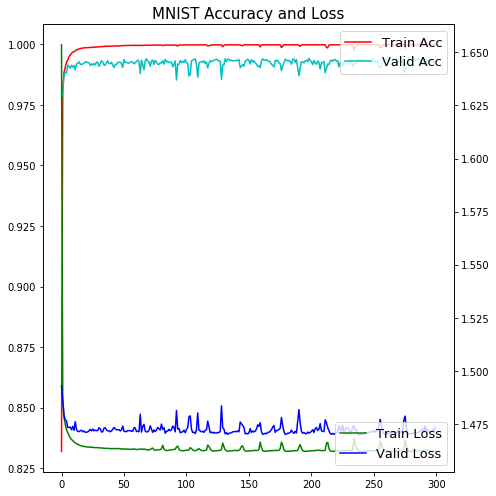

In [9]:
visualize_trainlogs(train=mnist_simplecnn_logs['train'][0],
                    valid=mnist_simplecnn_logs['validation'][0],
                    title='MNIST Accuracy and Loss',
                    savedir='../images/results/mnist_acc_loss_plot.png',
                    size=(7,7),
                    fontsize=15)

# CIFAR10

In [10]:
total_nb_size = sum(torch.numel(e) for _, e in cifar10_simplecnn['model'].items())
print('Number of Model Parameters: ', total_nb_size)
print('Best Accuracy: {:.2%}'.format(cifar10_simplecnn['best_acc']))
print('Best Epoch: ',cifar10_simplecnn['best_epoch'])

Number of Model Parameters:  2202573
Best Accuracy: 85.62%
Best Epoch:  271


In [11]:
cifar10_acc = calc_accuracy(model=cifar10_model, 
                          data=cifar10_testloader, 
                          true=np.array(cifar10_testloader.dataset.targets), 
                          idx2class=cifar10_idx2class, 
                          device=device)

Class [airplane  ] accuracy : 88.40%
Class [automobile] accuracy : 93.10%
Class [bird      ] accuracy : 77.30%
Class [cat       ] accuracy : 65.30%
Class [deer      ] accuracy : 87.50%
Class [dog       ] accuracy : 82.80%
Class [frog      ] accuracy : 90.20%
Class [horse     ] accuracy : 85.50%
Class [ship      ] accuracy : 92.00%
Class [truck     ] accuracy : 90.40%

Total accuracy: 85.25%


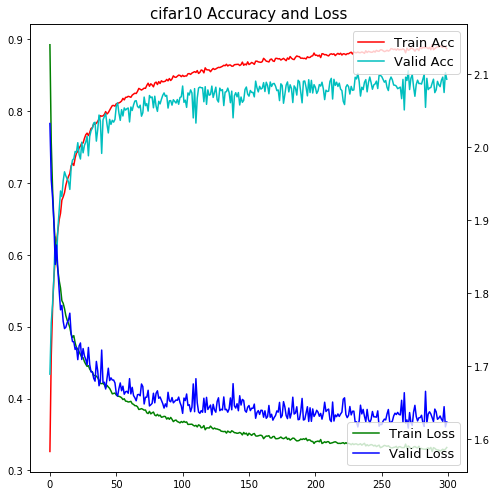

In [12]:
visualize_trainlogs(train=cifar10_simplecnn_logs['train'][0],
                    valid=cifar10_simplecnn_logs['validation'][0],
                    title='cifar10 Accuracy and Loss',
                    savedir='../images/results/cifar10_acc_loss_plot.png',
                    size=(7,7),
                    fontsize=15)